In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import cv2 
import os
from pathlib import Path
import json
%matplotlib inline

In [2]:
dir = '/root/capsule/data/behavior_711042_2024-09-13_09-19-15/behavior-videos/bottom_camera.avi'

In [3]:
def video_info_check(dir):
    base_name = os.path.splitext(os.path.basename(dir))[0]
    path_name = os.path.dirname(dir)
    video_info = dict()
    video_info['video_file'] = dir
    video_info['video_exist'] = os.path.exists(video_info['video_file'])
    video_info['timestamps_file'] = os.path.join(path_name, f"{base_name}.csv")
    video_info['timestamps_exist'] = os.path.exists(video_info['timestamps_file'])
    video_info['output_dir'] = os.path.join('/root/capsule/results', base_name)
    return video_info  

In [4]:
video_info = video_info_check(dir)
with open("video_qm.json", "w") as json_file:
    json.dump(video_info, json_file, indent=4, sort_keys=True)

In [5]:
def cal_video_temporal_qm(video_info):
    video_temporal_qm = dict()
    video_temporal_qm['IFI_cdf_quantile'] = np.arange(0, 105, 5)
    video_temporal_qm['IFI_cdf_value'] = None
    video_temporal_qm['IFI_range'] = None
    video_temporal_qm['ITI_cdf_quantile'] = np.arange(0, 105, 5)
    video_temporal_qm['ITI_cdf_value'] = None
    video_temporal_qm['ITI_range'] = None
    video_temporal_qm['frame_count'] = None
    video_temporal_qm['timestamp_count'] = None
    hist_iti = None
    hist_ifi = None
    if not video_info['video_exist']:
        raise ValueError('Target video does not exist')
    else:
        video = cv2.VideoCapture(video_info['video_file'])
        video_temporal_qm['frame_count'] = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        if video_info['timestamps_exist']:
            video_meta_data = pd.read_csv(video_info['timestamps_file'], header = None)
            video_temporal_qm['timestamp_count'] = len(video_meta_data)
            ITI = np.diff(video_meta_data[0]*1000)
            IFI = np.diff(video_meta_data[2]/1000000)
            video_temporal_qm['IFI_cdf_value'] = np.percentile(IFI, video_temporal_qm['IFI_cdf_quantile'])
            video_temporal_qm['ITI_cdf_value'] = list(np.percentile(ITI, video_temporal_qm['ITI_cdf_quantile']))
            video_temporal_qm['IFI_range'] = [np.min(IFI), np.max(IFI)]
            video_temporal_qm['ITI_range'] = [np.min(ITI), np.max(ITI)]
            hist_joint_all = sns.jointplot(x = ITI, y = IFI, kind = 'hist', bins = 10,
                       stat='probability',marginal_ticks=True, 
                       marginal_kws=dict(bins=20, fill=True, stat='probability')).set_axis_labels(xlabel = 'Harp time (ms)', ylabel='Camera time')
            mode_range  = (ITI>=video_temporal_qm['ITI_cdf_value'][1]) & (ITI<=video_temporal_qm['ITI_cdf_value'][-2]) & (IFI>=video_temporal_qm['IFI_cdf_value'][1]) & (IFI <=video_temporal_qm['IFI_cdf_value'][-2])
            mode_range  = (ITI<=video_temporal_qm['ITI_cdf_value'][-2]) & (IFI<=video_temporal_qm['IFI_cdf_value'][-2])
            hist_joint_peak = sns.jointplot(x = ITI[mode_range], y = IFI[mode_range], kind = 'hist', bins = 10,
                       stat='probability',marginal_ticks=True, 
                       marginal_kws=dict(bins=20, fill=True, stat='probability')).set_axis_labels(xlabel = 'Harp time (ms)', ylabel='Camera time (ms)')
            hist_iti, ax = plt.subplots()
            ax.hist(ITI, bins=30)
            hist_ifi, ax = plt.subplots()
            ax.hist(IFI, bins=30)
    return hist_iti, hist_ifi, hist_joint_all, hist_joint_peak, video_temporal_qm

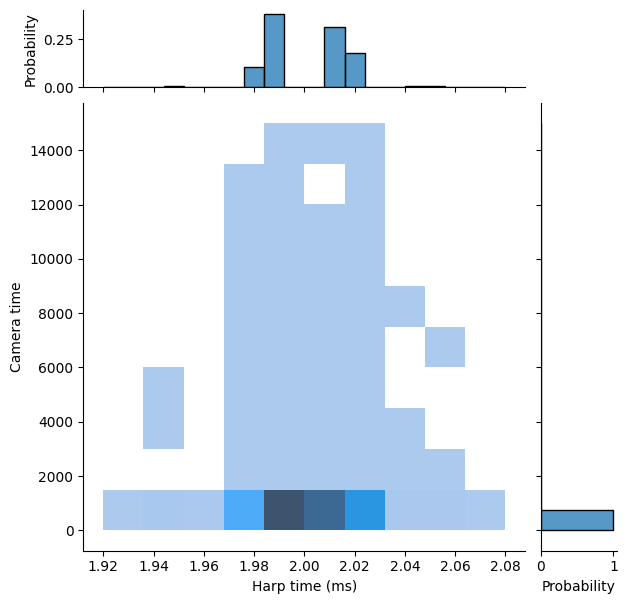

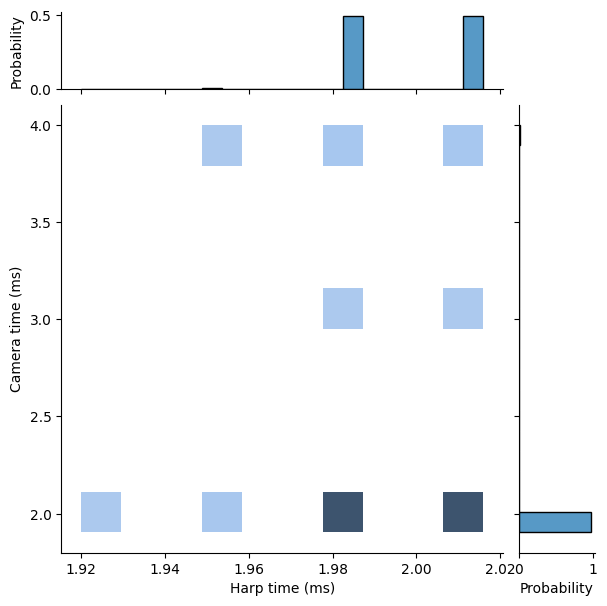

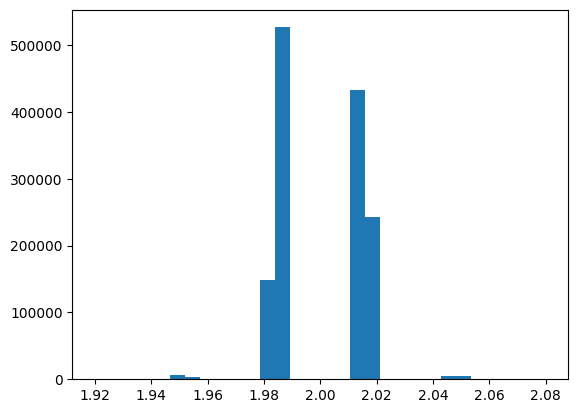

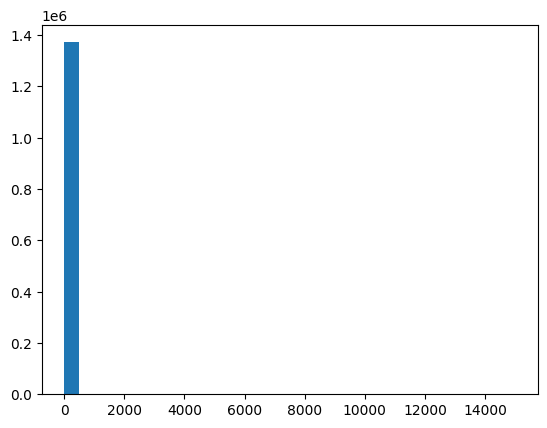

In [6]:
hist_iti, hist_ifi, hist_joint, hist_joint_peak, video_temporal_qm = cal_video_temporal_qm(video_info)

In [7]:
import json

file_path = os.path.join(video_info['output_dir'], 'video_qm.json')
file_path = '/root/capsule/code/video_qm.json'

# Read the existing data
with open(file_path, 'r') as file:
    try:
        existing_data = json.load(file)
    except json.JSONDecodeError:
        existing_data = []  # Initialize as an empty list if file is empty

# Check if the file is a list or dictionary and append accordingly
if isinstance(existing_data, list):
    existing_data.append(video_temporal_qm)
elif isinstance(existing_data, dict):
    existing_data.update(video_temporal_qm)
else:
    print("Unexpected JSON structure")

# Function to convert NumPy arrays and np.float64 to lists and floats
def convert_to_serializable(data):
    if isinstance(data, np.ndarray):
        return data.tolist()  # Convert ndarray to list
    elif isinstance(data, np.float64):
        return float(data)  # Convert np.float64 to Python float
    elif isinstance(data, dict):
        return {key: convert_to_serializable(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_to_serializable(item) for item in data]
    else:
        return data  # Return as is if already serializable

# Convert the existing data to a serializable format
existing_data = convert_to_serializable(existing_data)

# Write the updated data back to the file
with open(file_path, 'w') as file:
    json.dump(existing_data, file, indent=4)



In [9]:
type(video_temporal_qm)

dict